In [1]:
import requests
import pandas as pd
import numpy as np
import csv
from pathlib import Path

In [2]:
from os.path import exists

if not exists('../data/raw/popu.xlsx'):
    r = requests.get('https://www.abs.gov.au/statistics/people/population/regional-population/2021/32180DS0001_2001-21.xlsx',allow_redirects=True)
    open('../data/raw/population16-21.xlsx', 'wb').write(r.content)

if not exists('../data/raw/income14-19.xlsx'):
    r = requests.get('https://www.abs.gov.au/statistics/labour/earnings-and-working-conditions/personal-income-australia/2014-15-2018-19/6524055002_DO001.xlsx',allow_redirects=True)
    open('../data/raw/income14-19.xlsx', 'wb').write(r.content)


df = pd.read_excel('../data/raw/population16-21.xlsx', sheet_name='Table 1',header=7)  
# select Victoria data and modify column name
df = df.loc[df['S/T name'] == 'Victoria'][['SA2 code','no..15','no..16','no..17','no..18','no..19','no..20']]
df = df.rename(columns={'no..15': 2016, 'no..16': 2017,'no..17': 2018,'no..18': 2019,'no..19': 2020,'no..20': 2021})

dff = pd.read_excel('../data/raw/income14-19.xlsx', sheet_name='Table 1.4',header=6) 

# select Victoria data and modify column name

dff = dff.iloc[579:1041][['SA2','2014-15.4','2015-16.4','2016-17.4','2017-18.4','2018-19.4']]
dff = dff.rename(columns={'2014-15.4':'2014-15', '2015-16.4': '2015-16','2016-17.4': '2016-17','2017-18.4': '2017-18','2018-19.4': '2018-19'})

dff = dff.apply(pd.to_numeric, errors='coerce')


In [3]:


# natural growth rate without migration in Australia
mor_fer_rate = 1.0072

def predict22(row):  
    if row[2016] * mor_fer_rate * mor_fer_rate < row[2018] and row[2019] * mor_fer_rate * mor_fer_rate > row[2021]:
        # have a high prob that this district is influenced by Covid
        return max(row[2021] * mor_fer_rate, 0)
    else:
        # have a high prob that this district is not very influenced by Covid
        return max((row[2021] - row[2016]) / 5 + row[2021], 0)

def predict23(row):  
    if row[2016] * mor_fer_rate * mor_fer_rate < row[2018] and row[2019] * mor_fer_rate * mor_fer_rate > row[2021]:
        return max(row[2020] * mor_fer_rate * mor_fer_rate, 0)
    else:
        return max((row[2021] - row[2016]) / 5 * 2 + row[2021], 0)

df[2022] = df.apply(predict22, axis=1)
df[2023] = df.apply(predict23, axis=1)
df = df.astype({'SA2 code': 'int'})

filepath = Path('../data/curated/predictpopu.csv')  
df[['SA2 code',2022,2023]].to_csv(filepath, index=False)  





In [4]:
def rate(row): 
    if np.isnan(row['2018-19']):
        # entry is nan, no income in this district
        return 0
    else:
        if not np.isnan(row['2014-15']):
            # calculate growth rate over the past 5 years
            return (row['2018-19'] - row['2014-15']) / 5 / row['2018-19']
        else:
            # 2014 entry is nan, so use 2016 instead
            return (row ['2018-19'] - row ['2016-17']) / 5 / row['2018-19']

def predict2019(row):
    if np.isnan(row['2018-19']):
        # entry is nan
        return 0.0
    return max(float(row['2018-19']) * (1 + 1 * row['growthrate']),0)

# is this two times the growth rate?
# also, do we need max(..., 0)?
def predict2020(row):
    return max(row['2019']* (1 + 2 * row['growthrate']),0)
def predict2021(row):
    return max(row['2020']* (1 + 0.3 * row['growthrate']),0)
def predict2022(row):
    return max(row['2021']* (1 + 2 * row['growthrate']),0)
def predict2023(row):
    return max(row['2022']* (1 + 2 * row['growthrate']),0)

dff['growthrate'] = dff.apply(rate, axis=1)
dff['2019'] = dff.apply(predict2019, axis=1)
dff['2020'] = dff.apply(predict2020, axis=1)
dff['2021'] = dff.apply(predict2021, axis=1)
dff['2022'] = dff.apply(predict2022, axis=1)
dff['2023'] = dff.apply(predict2023, axis=1)

filepath = Path('../data/curated/predictincome.csv')  
dff[['SA2','2019','2020','2021','2022','2023']].to_csv(filepath, index=False)

<BarContainer object of 10 artists>

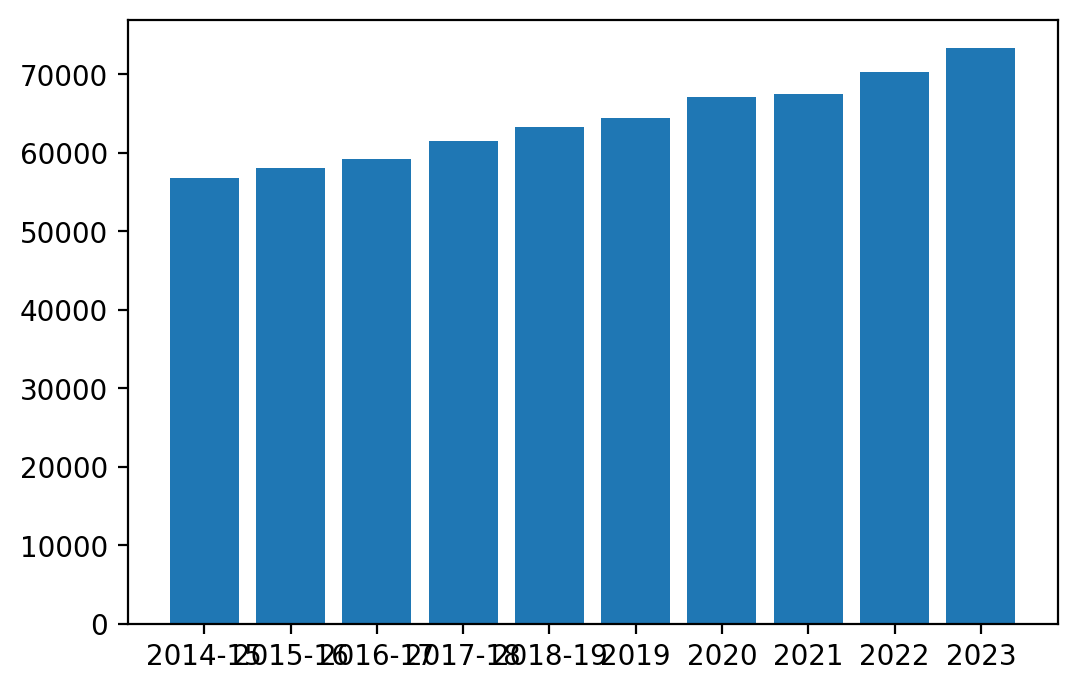

In [5]:
# I want to check to see if the predictions are reasonable

import matplotlib.pyplot as plt

years = list(set(dff.columns)-set(['SA2', 'growthrate']))
years.sort()

plt.rc('figure', dpi=200)

plt.bar(years, dff.mean()[years])

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  1.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  1.,  5.,  5.,  8., 14., 14., 26., 28.,
        29., 35., 31., 27., 28., 32., 31., 19., 20.,  7.,  9.,  7., 11.,
         9.,  2.,  5.,  5.,  9.,  6.,  2.,  8.,  0.,  2.,  1.,  5.,  1.,
         4.,  1.,  2.,  0.,  1.,  0.,  1.,  1.,  0.,  0.,  0.,  0.,  0.,
         1.,  1.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.]),
 array([     0.        ,   2309.47706959,   4618.95413918,   6928.43120877,
          9237.90827835,  11547.38534794,  13856.86241753,  16166.33948712,
         18475.81655671,  20785.2936263 ,  23094.77069589,  25404.24776547,
         27713.72483506,  30023.20190465,  32332.67897424,  34642.15604383,
         36951.63311342,  39261.11018301,  41570.58725259,  43880.06432218,
         46189.54139177,  48499.01846136,  50808.49553

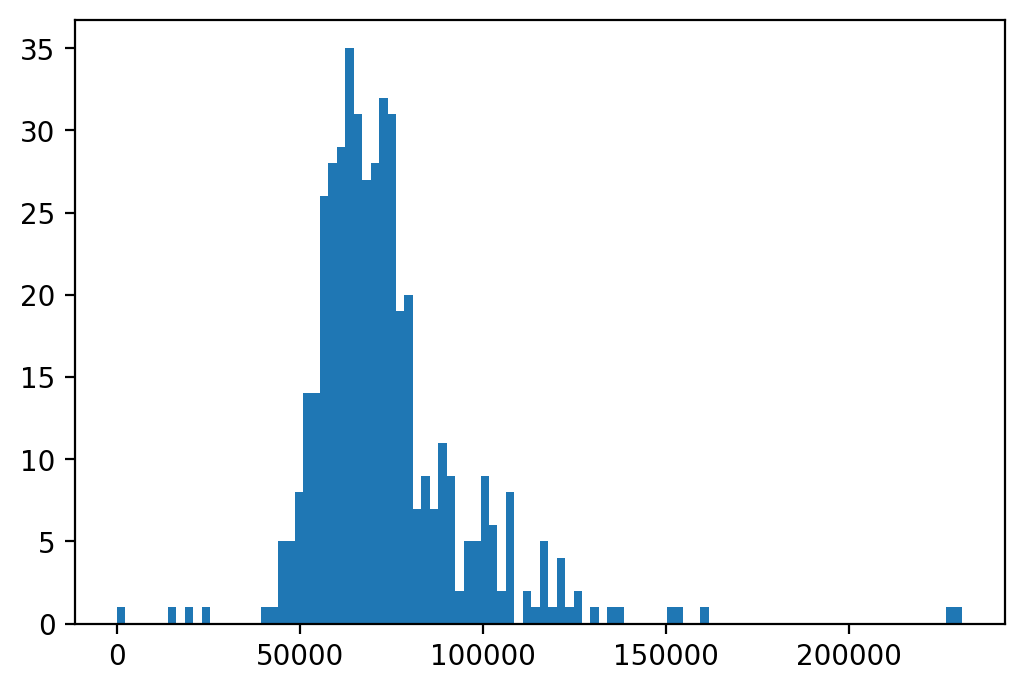

In [10]:
plt.hist(dff['2023'], bins=100)

In [11]:
# these are abit odd
dff[dff['2023'] < 30000]

,SA2,2014-15,2015-16,2016-17,2017-18,2018-19,growthrate,2019,2020,2021,2022,2023
658,205021080,NaN,NaN,23098.0,22659.0,23162.0,0.000553,23174.8,23200.414147,23204.260516,23229.907225,23255.582280
661,205021083,NaN,NaN,NaN,NaN,NaN,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
666,205031088,22726.0,32979.0,27364.0,32022.0,21230.0,-0.014093,20930.8,20340.833409,20254.832787,19683.919366,19129.098012
709,206051131,132566.0,224340.0,116157.0,87256.0,70348.0,-0.176886,57904.4,37419.405634,35433.711161,22898.232449,14797.463549
